# **CS 405: Deep Learning | Lab**
---
### **Experiment 4: Train and Implement Handwritten Digit Classification  using Convolutional Neural Networks (CNNs) on the MNIST Dataset**

**Student Name:** Nabeel Shan  
**Registration No:** 468752

---

## Objective
To implement and train deep learning models in PyTorch for classifying handwritten digits using the **MNIST dataset**. This lab compares two architectures:
1.  **Fully Connected Neural Network (FCNN)**
2.  **Convolutional Neural Network (CNN)**

In [ ]:
# !pip install mitdeeplearning --quiet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import mitdeeplearning as mdl

# Check for GPU
assert torch.cuda.is_available(), "Please enable GPU from runtime settings"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Transform to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Download datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 467kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.7MB/s]


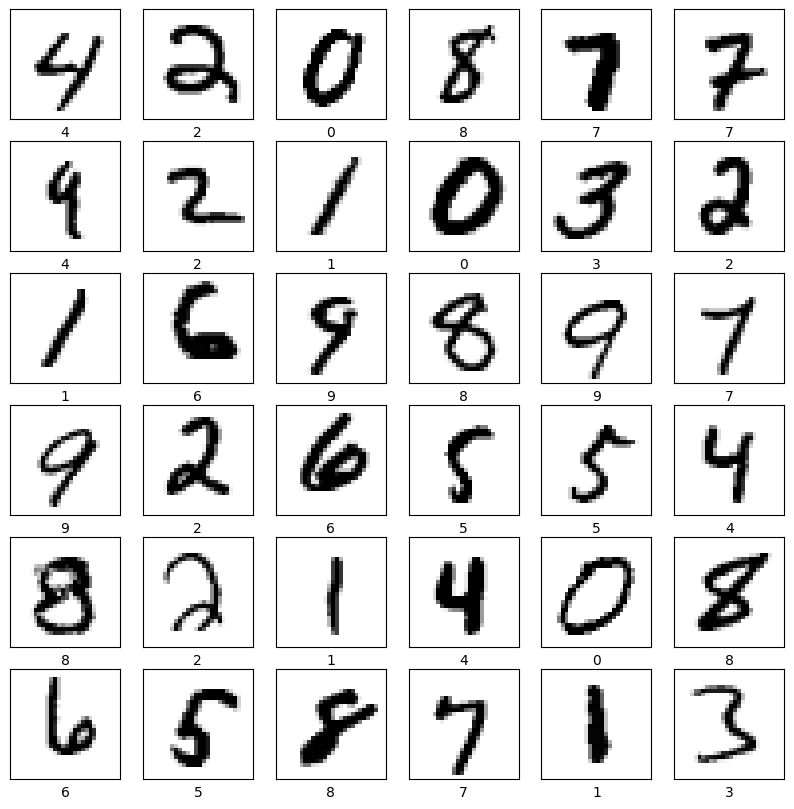

In [ ]:
# Visualize samples
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    image, label = train_dataset[image_ind]
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label)
plt.show()

# Fully Connected Neural Network (FCNN)

In [ ]:
class FullyConnectedModel(nn.Module):
    def __init__(self):
        super(FullyConnectedModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

fc_model = FullyConnectedModel().to(device)

In [ ]:
def train(model, dataloader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_pred = 0
        total_pred = 0

        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()*images.size(0)

            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

        total_epoch_loss = total_loss / total_pred
        epoch_accuracy = correct_pred / total_pred
        print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(fc_model.parameters(), lr=0.1)
EPOCHS = 5
BATCH_SIZE = 64

trainset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train(fc_model, trainset_loader, loss_function, optimizer, EPOCHS)

Epoch 1, Loss: 0.4463, Accuracy: 0.8786
Epoch 2, Loss: 0.2306, Accuracy: 0.9339
Epoch 3, Loss: 0.1738, Accuracy: 0.9504
Epoch 4, Loss: 0.1402, Accuracy: 0.9601
Epoch 5, Loss: 0.1171, Accuracy: 0.9669


In [ ]:
def evaluate(model, dataloader, loss_function):
    model.eval()
    test_loss = 0
    correct_pred = 0
    total_pred = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

    test_loss /= total_pred
    test_acc = correct_pred / total_pred
    return test_loss, test_acc

In [ ]:
test_loss, test_acc = evaluate(fc_model, testset_loader, loss_function)
print('FCNN Test accuracy:', test_acc)

FCNN Test accuracy: 0.9672


# Train CNN with Live Plotting

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(36 * 7 * 7, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

cnn_model = CNN().to(device)

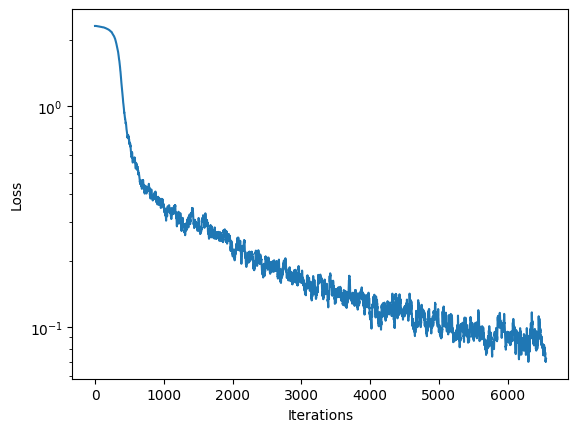

100%|██████████| 938/938 [00:09<00:00, 95.26it/s]


Epoch 7, Loss: 0.0897, Accuracy: 0.9728


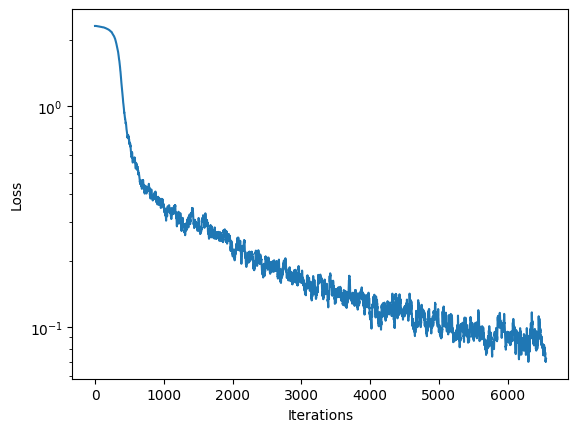

In [ ]:
# Hyperparameters
batch_size = 64
epochs = 7
learning_rate = 1e-2

# Re-initialize model and optimizer
cnn_model = CNN().to(device)
optimizer = optim.SGD(cnn_model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# DataLoaders
trainset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testset_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Plotting tools
loss_history = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()

cnn_model.train()

for epoch in range(epochs):
    total_loss = 0
    correct_pred = 0
    total_pred = 0

    for idx, (images, labels) in enumerate(tqdm(trainset_loader)):
        images, labels = images.to(device), labels.to(device)

        logits = cnn_model(images)
        loss = loss_function(logits, labels)

        # Update plots
        loss_value = loss.item()
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(logits, dim=1)
        correct_pred += (predicted == labels).sum().item()
        total_pred += labels.size(0)
        total_loss += loss.item()*labels.size(0)

    total_epoch_loss = total_loss / total_pred
    epoch_accuracy = correct_pred / total_pred
    print(f"Epoch {epoch + 1}, Loss: {total_epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

In [ ]:
test_loss, test_acc = evaluate(cnn_model, testset_loader, loss_function)
print('CNN Test accuracy:', test_acc)

CNN Test accuracy: 0.9693


In [ ]:
# @title Live Model Demonstration for Evaluation
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_evaluation(model, dataset, num_images=10):
    """
    Picks random images from the test set and visualizes the model's prediction.
    Green title = Correct Prediction
    Red title = Incorrect Prediction
    """
    model.eval()

    # Pick random indices
    indices = np.random.choice(len(dataset), num_images, replace=False)

    # Set up the plot grid
    cols = 5
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(15, 3.5 * rows))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            image_tensor = image.to(device).unsqueeze(0) # Add batch dimension

            # Forward pass
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            # Convert to values
            predicted_label = predicted.item()
            conf_score = confidence.item() * 100

            # Plotting
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(image.squeeze(), cmap='gray_r') # gray_r for black digit on white background like paper
            plt.axis('off')

            # Color code based on accuracy
            color = 'green' if predicted_label == true_label else 'red'

            title_text = f"Pred: {predicted_label} ({conf_score:.1f}%)\nTrue: {true_label}"
            ax.set_title(title_text, color=color, fontsize=12, fontweight='bold')

    plt.suptitle("Final Model Evaluation on Random Test Images", fontsize=16)
    plt.tight_layout()
    plt.show()

Generating evaluation report...


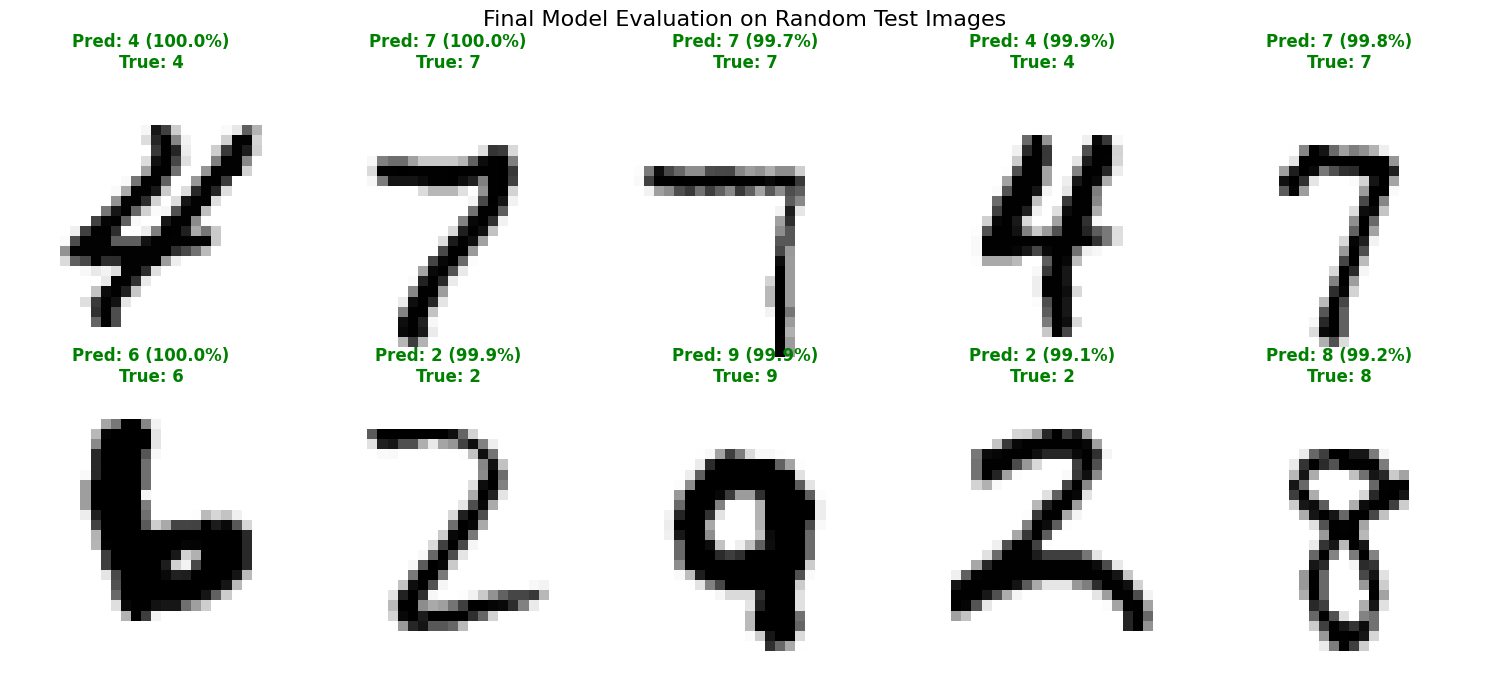

In [ ]:
# Run the visualization
print("Generating evaluation report...")
visualize_evaluation(cnn_model, test_dataset, num_images=10)